In [1]:
#| default_exp activations

In [2]:
#|export
from __future__ import annotations
import random, math, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial

from torch import tensor, nn, optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset

from miniai.datasets import *
from miniai.learner import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

A way to make reproducible experiment when needed:

In [18]:
#|export
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

-- Load the fashion mnist dataset -- 

In [5]:
x,y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
bs = 1024

In [7]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [8]:
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

In [9]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [10]:
def cnn_layers():
    return [
        conv(1, 8, ks=5),        #14x14
        conv(8, 16),             #7x7
        conv(16, 32),            #4x4
        conv(32, 64),            #2x2
        conv(64, 10, act=False), #1x1
        nn.Flatten()
    ]

In [11]:
from torcheval.metrics import MulticlassAccuracy

In [12]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs=  [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [13]:
def fit(model, epochs=1, xtra_cbs=[]):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+xtra_cbs)
    learn.fit(epochs)
    return learn

In [19]:
Learner??

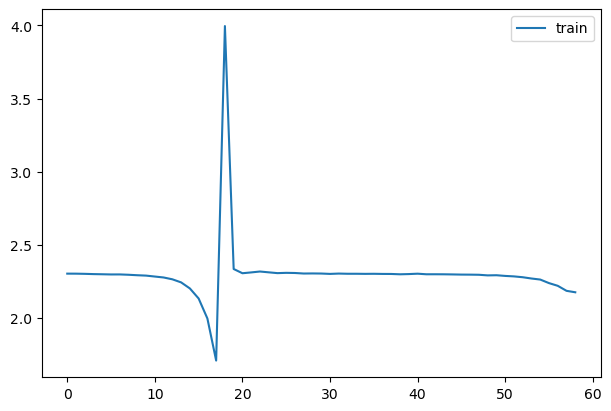

In [141]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

The learning rate is high, so it's not surprising to see the error jump as the gradient steps send the weights too far in directions away from the minimum of the landscape. 
But let's try to undersand finely what is happening in the weights.

In [20]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x
    
    def __iter__(self): return iter(self.layers)

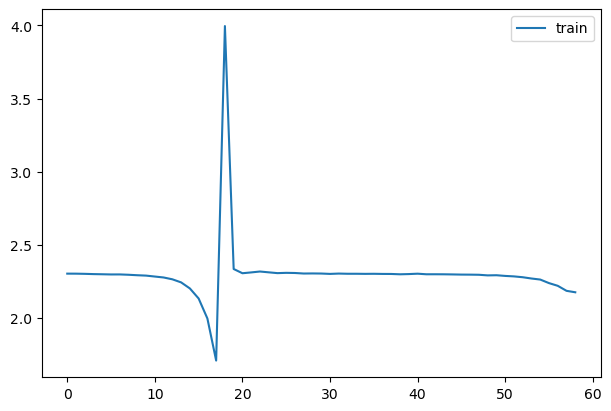

In [21]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

We can now plot the evolution of each layer's mean and std during the training. (In cnn_layers, there are 6 layers, the last one being just a flatten, so the last two layers mean/std will overlap.)

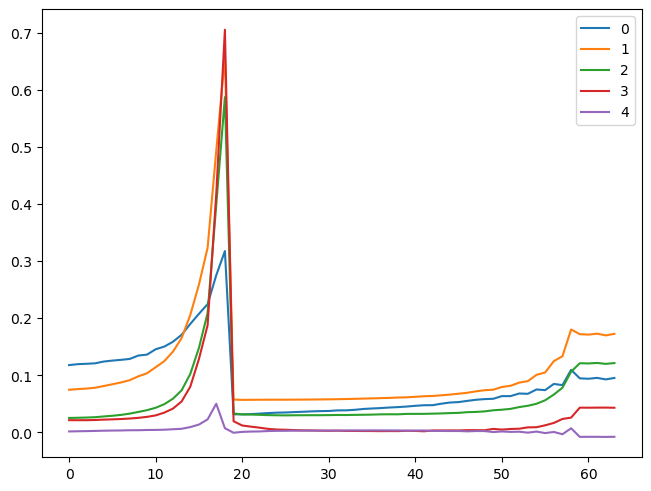

In [33]:
for l in model.act_means[:-1]: plt.plot(l)
plt.legend(range(5));

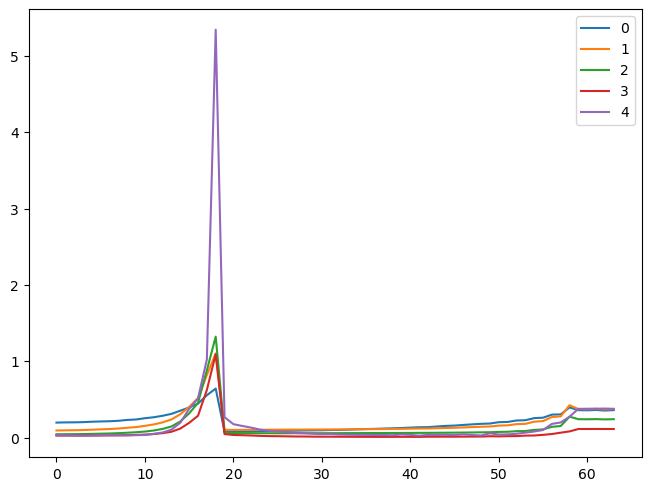

In [32]:
for l in model.act_stds[:-1]: plt.plot(l)
plt.legend(range(5));

We do not need to use a custom Sequential model, we can use Pytorch hooks to do that.

### Pytorch hooks

hooks can be attached to `nn.Module`s and are called in the forward pass or in the backward pass. We need to pass in a function that has 3 arguments, module, inputs, outputs. This function will be called by the hook each time the module is used (in the forward or backward direction depending on the hook type).

In [1]:
set_seed??

Object `set_seed` not found.


In [40]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

Same as before, we track the means and stds with two lists

In [41]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

We define the function called by the hook, there will be one hook and one function for each layer of the model:

In [42]:
def append_stats(i, model, inputs, outputs):
    act_means[i].append(to_cpu(outputs).mean())
    act_stds[i].append(to_cpu(outputs).std())

And we attach each function to its respective layer:

In [43]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats,i))

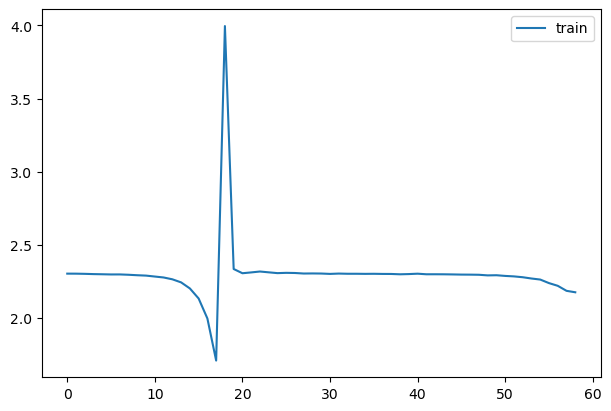

In [44]:
fit(model)

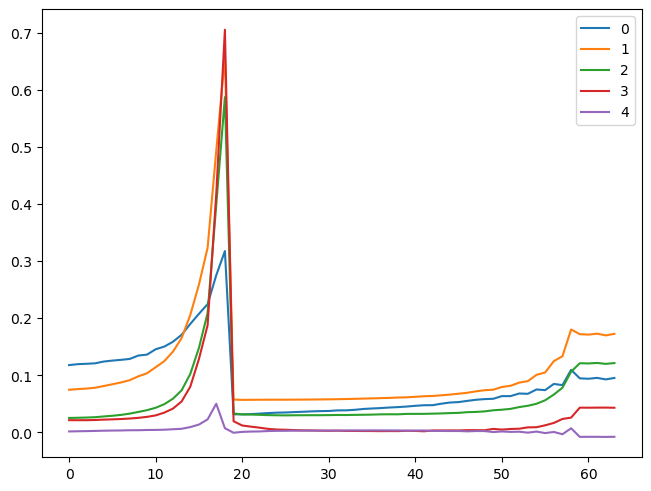

In [46]:
for l in act_means[:-1]: plt.plot(l)
plt.legend(range(5));

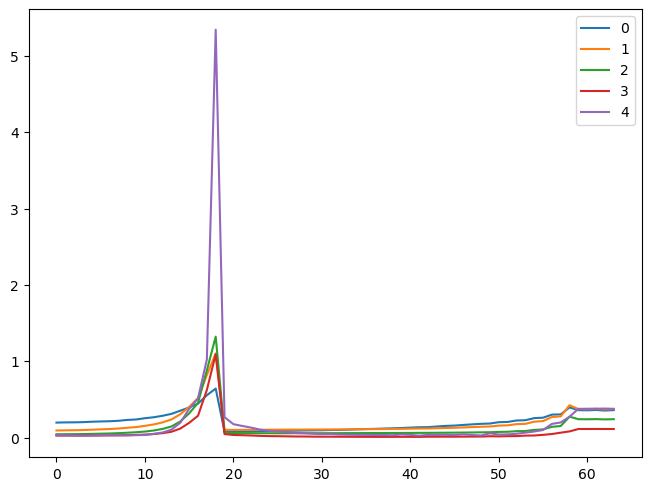

In [47]:
for l in act_stds[:-1]: plt.plot(l)
plt.legend(range(5));

Same result, now can wrap this in a Hook class.

### Hook class

The hooks must be removed when deleted to make sure there is no memory remanence problem.

In [87]:
#|export
class Hook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
        self.mod_nm = type(m).__name__
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

And we can redefine the append stats function. We initialize the lists as attributes of the Hook class in the append stats function because they are specific to this particular use. We could have instantiated the lists in the Hook class constructor but there might be different types of tracking attributes for differnet types of hooks, so this way it is more general.

In [22]:
def append_stats(hook, model, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [23]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

The model children are the first layer of modules that the model module contains. Flatten is one of them, but it's a duplicate of the information of the previous Flatten.

In [24]:
for m in model.children(): 
    print(type(m).__name__)

Sequential
Sequential
Sequential
Sequential
Conv2d
Flatten


In [201]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

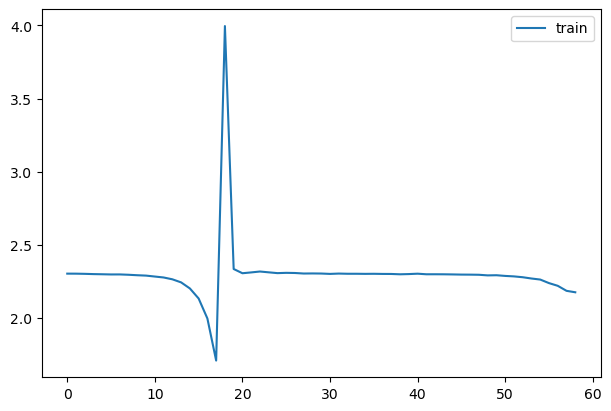

In [203]:
learn = fit(model)

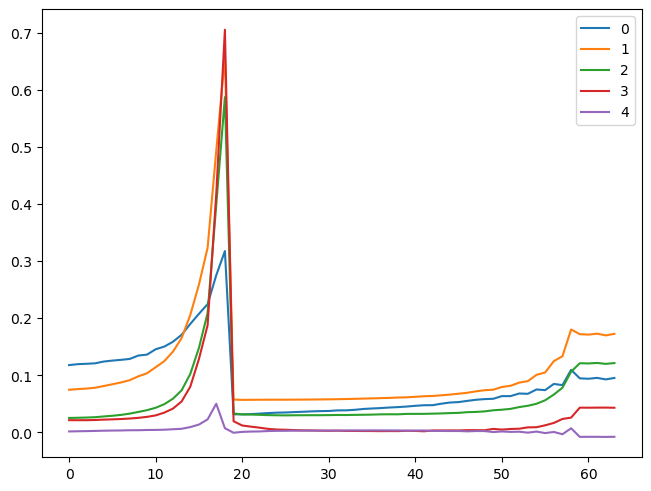

In [206]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5))

Now we can bundle all hooks in a Hooks class.

### Hooks class

The Hooks class will be used as a context manager, it will inherit from `list` and contain all the hooks attached to the model's module:

In [25]:
#|export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m,f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i): 
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [26]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

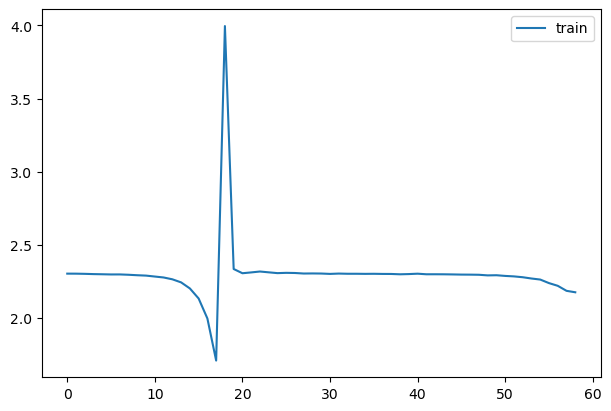

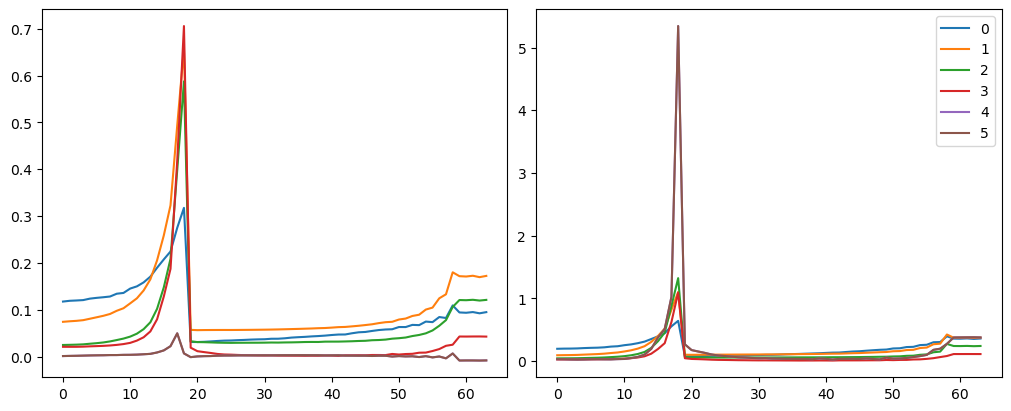

In [167]:
with Hooks(model, append_stats) as hooks:
    learn0 = fit(model)
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6))

We can build another visual graph, we can plot the distribution of the magnitude of the activations for each layer along the training. It will give a clear picture of the proportion of activations that are used, learning or 'dead'.

### HooksCallback

In [138]:
#|export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop): # mod_filters is a function that filters the modules to hook
        fc.store_attr()
        super().__init__()
    
    def before_fit(self):
        mods = fc.filter_ex(self.learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, self._hookfunc)
    
    def _hookfunc(self, *args, **kwargs): # checks if training 
        if self.learn.model.training: self.hookfunc(*args, **kwargs)
    
    def after_fit(self): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [28]:
fit??

We can filter the type of modules that have a hook with the `mod_filter` function. In the previous case, the calculation was made after the `ReLU` of each `Sequential` group and after the last Conv2d layer. 

In [31]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
# hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.ReLU))

In [32]:
model.modules

<bound method Module.modules of Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)>

In [41]:
# fc.noop??
# fc.filter_ex??
# fc.risinstance??
# fc.tuplify??
# fc.listify??

In [34]:
fc.risinstance(nn.Conv2d, model[0][0])

True

In [35]:
model[0]

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)

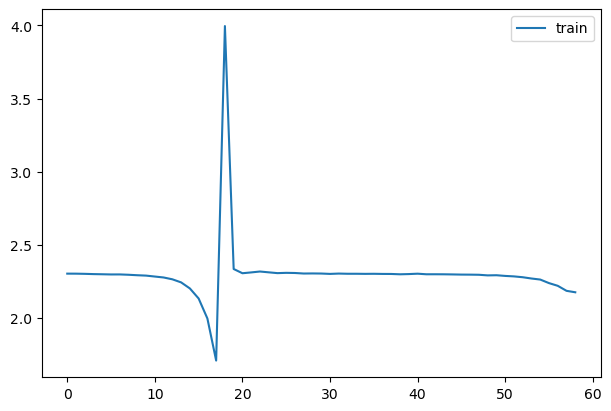

In [36]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc])

Here, due to selecting only `Conv2d` layers before `ReLU`, the ouputs are positive and negative. 

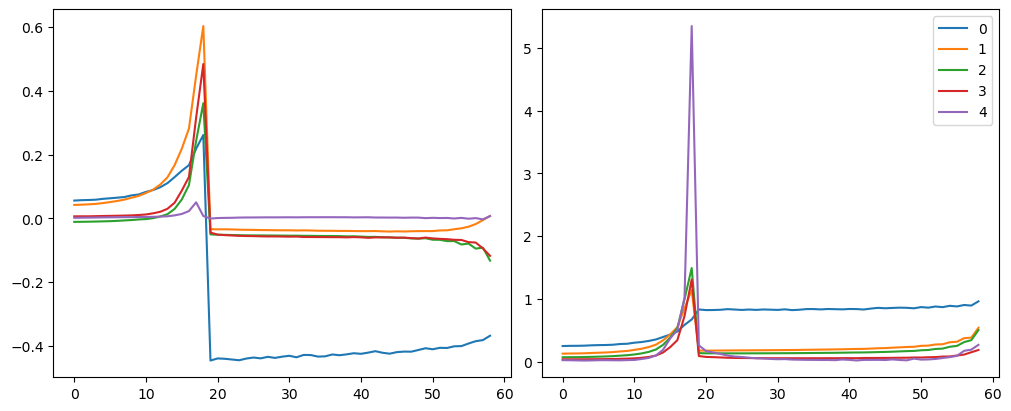

In [42]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6))

### Histograms

We can find a way to visually see if the layers are learning correctly. It's by looking at the distribution of the absolute value of the activation values in each layer. We can build a histogram with 40 bins going from 0 to 10, each bin corresponding to a segment of 0.25: `acts.abs().histc(40,0,10)`

In [48]:
#|export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

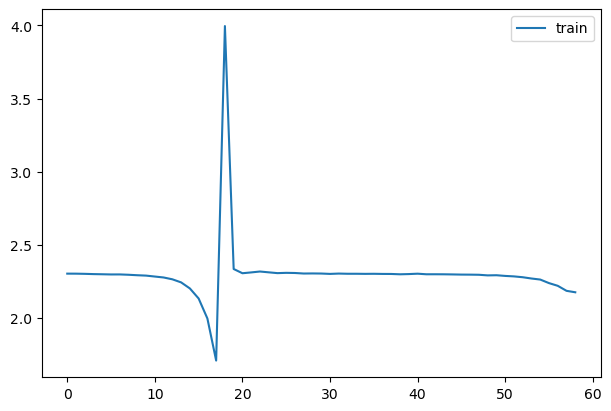

In [88]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [89]:
#|export
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

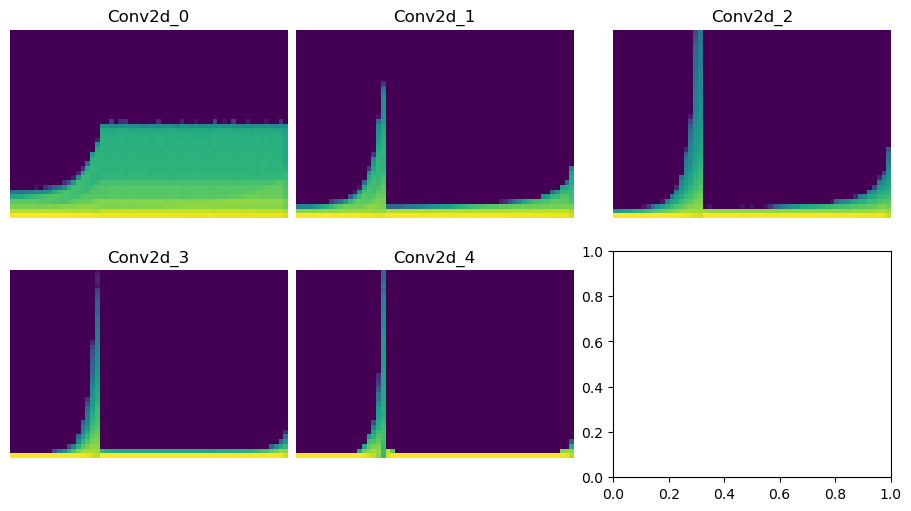

In [90]:
fig,axes = subplots(2,3, figsize=(9,5))
for i,(ax,h) in enumerate(zip(axes.flatten(), hc)):
    ax.set_title(f'{h.mod_nm}_{i}')
    show_image(get_hist(h), ax, origin='lower')

In [66]:
get_grid??

In [92]:
# fig,axes = get_grid(len(hc), figsize=(11,5))
# for i,(ax,h) in enumerate(zip(axes.flatten(), hc)):
#     show_image(get_hist(h), ax, origin='lower')

In [58]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

We can see that for each layer of the model, the values are mostly at or close to 0 (The yellow region fg the histogram). 
The number of activations that are not really contributing to the result is thus dominant. We can look at the proportion of the activations that are in the first bin:

In [105]:
#|export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

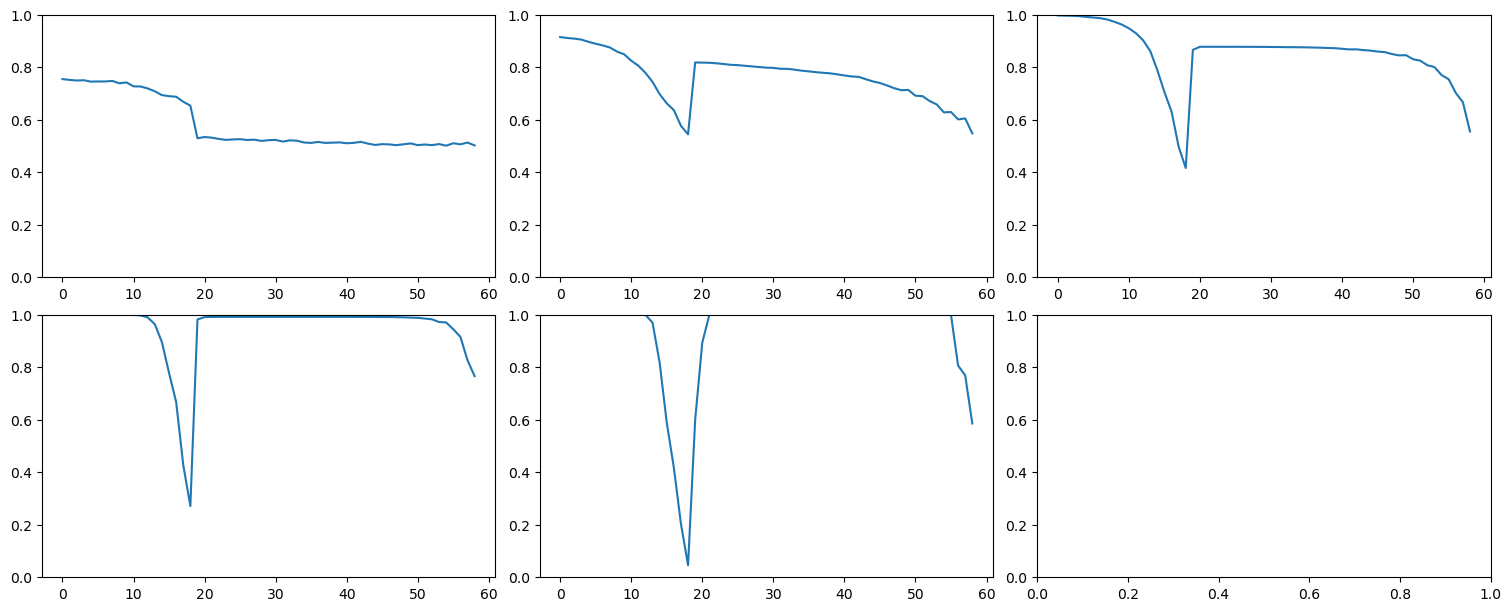

In [112]:
fig,axes = subplots(2,3, figsize=(15,6))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

And here we can clearly see that a majority (more than 50% and sometimes close to 100%) of the activations are within the first bin, that is between 0 and 0.25 in absolute value.

### ActivationStats

In [2]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)
        
    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            show_image(get_hist(h), ax, origin='lower')
                
    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)
    
    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(range(len(self)))

NameError: name 'HooksCallback' is not defined

In [165]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

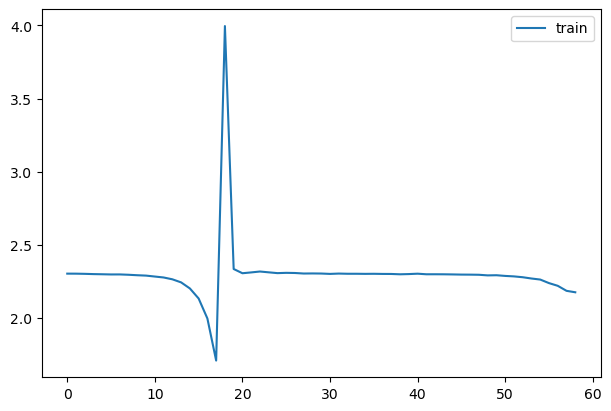

In [166]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

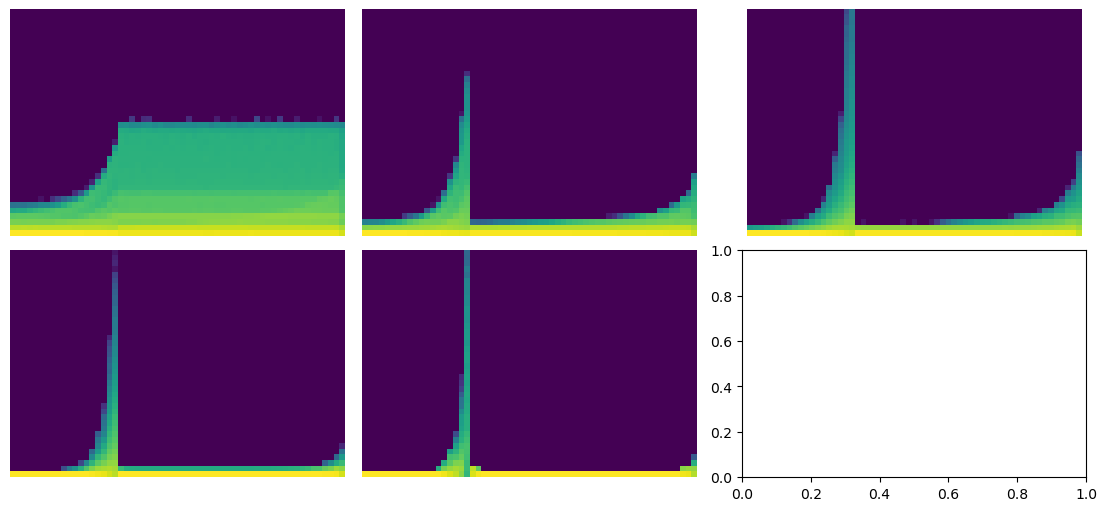

In [167]:
astats.color_dim()

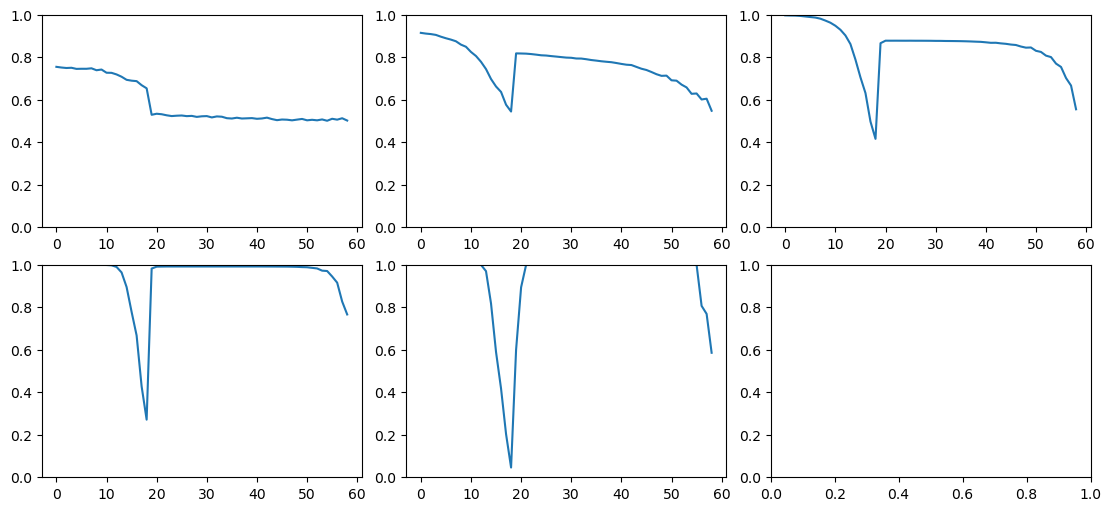

In [168]:
astats.dead_chart()

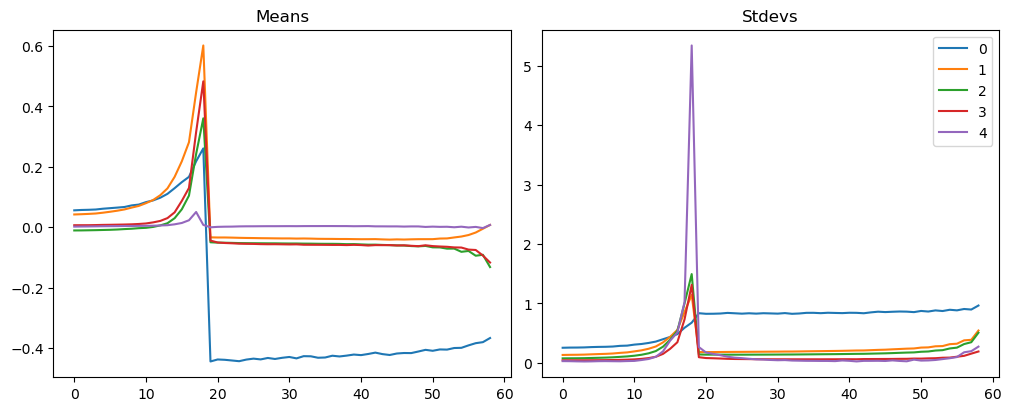

In [169]:
astats.plot_stats()

#### Export

In [3]:
import nbdev; nbdev.nbdev_export()